In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
latent_dim = 64
batch_size = 128
epochs = 20
lr = 2e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 41.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.03MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.09MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.89MB/s]


In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z)

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )

    def forward(self, x):
        return self.net(x)


In [22]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784 + latent_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            # nn.Sigmoid()
        )

    def forward(self, x, z):
        xz = torch.cat([x, z], dim=1)
        return self.net(xz)

In [23]:
G = Generator().to(device)
D = Discriminator().to(device)
E = Encoder().to(device)

# criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()


opt_ge = optim.Adam(list(G.parameters()) + list(E.parameters()),lr = lr,betas = (0.5,0.999))
opt_d = optim.Adam(D.parameters(),lr = lr,betas = (0.5,0.999))

In [24]:
for epoch in range(epochs):
    for imgs,_ in loader:
        imgs = imgs.view(imgs.size(0),-1).to(device)
        batch_size = imgs.size(0)

        real = torch.ones(batch_size,1).to(device)
        fake = torch.zeros(batch_size,1).to(device)

        # Train Generator
        
        z = torch.rand(batch_size,latent_dim).to(device)

        x_fake = G(z)
        z_real = E(imgs)

        D_real = D(imgs,z_real)
        D_fake = D(x_fake.detach(),z)

        d_loss = criterion(D_real,real) + criterion(D_fake,fake)
        opt_d.zero_grad()
        d_loss.backward()
        opt_d.step()

        # Train Discriminator + Encoder

        D_fake = D(G(z),z)
        D_real = D(imgs,E(imgs))

        ge_loss = criterion(D_real,fake) + criterion(D_fake,real)

        opt_ge.zero_grad()
        ge_loss.backward()
        opt_ge.step()
        
    print(
        f"Epoch [{epoch+1}/{epochs}] | "
        f"D Loss: {d_loss.item():.4f} | GE Loss: {ge_loss.item():.4f}"
    )
        

Epoch [1/20] | D Loss: 0.6040 | GE Loss: 4.1360
Epoch [2/20] | D Loss: 0.4230 | GE Loss: 5.9656
Epoch [3/20] | D Loss: 0.2903 | GE Loss: 9.6371
Epoch [4/20] | D Loss: 0.2661 | GE Loss: 11.5725
Epoch [5/20] | D Loss: 0.2464 | GE Loss: 9.5749
Epoch [6/20] | D Loss: 0.0834 | GE Loss: 14.2178
Epoch [7/20] | D Loss: 0.2021 | GE Loss: 11.7690
Epoch [8/20] | D Loss: 0.0217 | GE Loss: 42.9074
Epoch [9/20] | D Loss: 0.0701 | GE Loss: 13.9750
Epoch [10/20] | D Loss: 0.1106 | GE Loss: 13.8961
Epoch [11/20] | D Loss: 0.3048 | GE Loss: 12.9626
Epoch [12/20] | D Loss: 0.0213 | GE Loss: 16.5164
Epoch [13/20] | D Loss: 0.1832 | GE Loss: 14.6017
Epoch [14/20] | D Loss: 0.0834 | GE Loss: 18.1446
Epoch [15/20] | D Loss: 0.0467 | GE Loss: 17.0497
Epoch [16/20] | D Loss: 0.0492 | GE Loss: 22.2152
Epoch [17/20] | D Loss: 0.0115 | GE Loss: 25.3267
Epoch [18/20] | D Loss: 0.0034 | GE Loss: 23.9657
Epoch [19/20] | D Loss: 0.0007 | GE Loss: 33.3294
Epoch [20/20] | D Loss: 0.0011 | GE Loss: 26.7863


In [25]:
print(D_real.mean().item(), D_fake.mean().item())

19.732074737548828 -7.053308010101318


In [26]:
class MNISTFeatureNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128)
        )

    def forward(self, x):
        return self.net(x)


In [27]:
feature_net = MNISTFeatureNet().to(device)
feature_net.eval()

MNISTFeatureNet(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=3136, out_features=128, bias=True)
  )
)

In [28]:
import numpy as np

def compute_statistics(features):
    mu = features.mean(axis=0)
    sigma = np.cov(features, rowvar=False)
    return mu, sigma


In [30]:
def matrix_sqrt(mat):
    eigvals, eigvecs = np.linalg.eigh(mat)
    eigvals = np.maximum(eigvals, 0)
    return eigvecs @ np.diag(np.sqrt(eigvals)) @ eigvecs.T

In [31]:
def fid_from_stats(mu1, sigma1, mu2, sigma2):
    diff = mu1 - mu2
    covmean = matrix_sqrt(sigma1 @ sigma2)
    return diff @ diff + np.trace(sigma1 + sigma2 - 2 * covmean)


In [36]:
import matplotlib.pyplot as plt

@torch.no_grad()
def evaluate_bigan(E, G, loader, num_images=100, display=10):
    E.eval()
    G.eval()

    real_imgs = []
    recon_imgs = []

    for imgs, _ in loader:
        imgs = imgs.to(device)

        z = E(imgs.view(imgs.size(0), -1))
        recon = G(z).view(-1, 1, 28, 28)

        real_imgs.append(imgs)
        recon_imgs.append(recon)

        if len(torch.cat(real_imgs)) >= num_images:
            break

    real_imgs = torch.cat(real_imgs)[:num_images]
    recon_imgs = torch.cat(recon_imgs)[:num_images]

    # --------------------
    # Feature extraction
    # --------------------
    real_feat = feature_net(real_imgs).cpu().numpy()
    recon_feat = feature_net(recon_imgs).cpu().numpy()

    mu_r, sigma_r = compute_statistics(real_feat)
    mu_f, sigma_f = compute_statistics(recon_feat)

    fid = fid_from_stats(mu_r, sigma_r, mu_f, sigma_f)

    print(f"\nReconstruction FID (Real vs E→G): {fid:.4f}\n")

    # --------------------
    # Visualization
    # --------------------
    fig, axes = plt.subplots(display, 2, figsize=(4, 2 * display))

    for i in range(display):
        axes[i, 0].imshow(real_imgs[i].cpu().squeeze(), cmap="gray")
        axes[i, 0].set_title("Real")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(recon_imgs[i].cpu().squeeze(), cmap="gray")
        axes[i, 1].set_title("Reconstructed")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()


Reconstruction FID (Real vs E→G): 0.3058



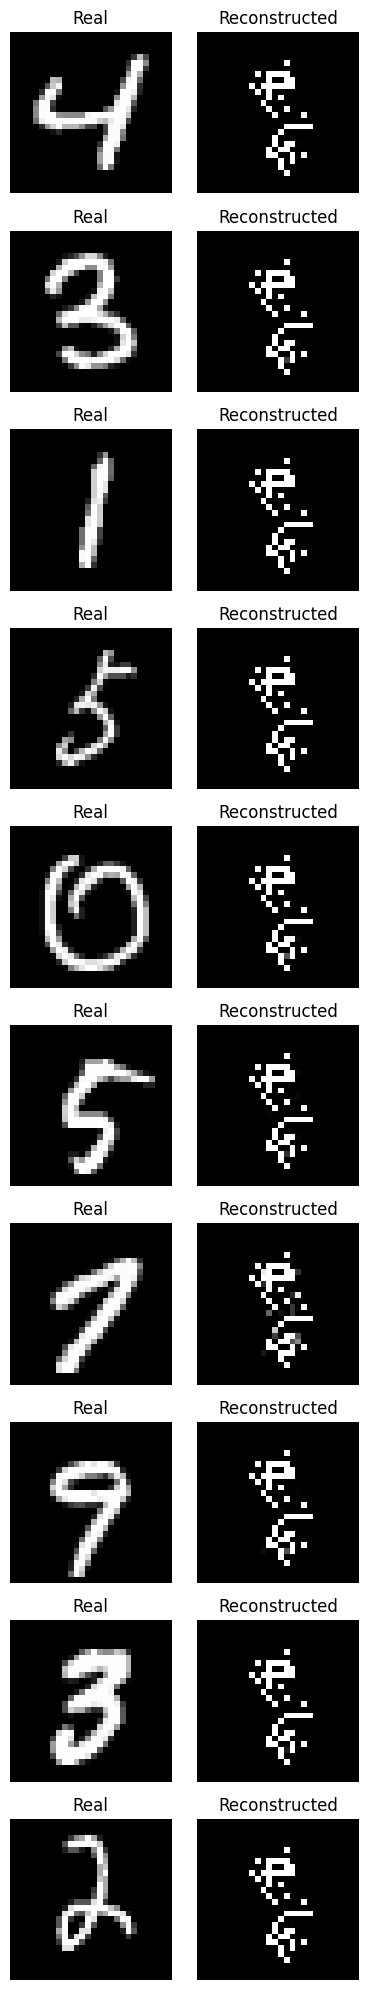

In [37]:
evaluate_bigan(E, G, loader, num_images=100, display=10)

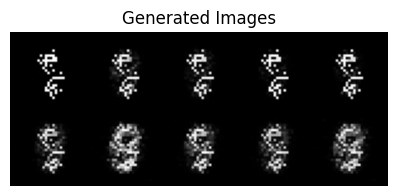

In [47]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

G.eval()
with torch.no_grad():
    z = torch.randn(10, latent_dim).to(device)
    imgs_gen = G(z)
    imgs_gen = imgs_gen.view(imgs_gen.size(0), 1, 28, 28)

    # Rescale from [-1, 1] → [0, 1]
    
    imgs_gen = (imgs_gen * 0.5 + 0.5)

# Create a grid
grid = vutils.make_grid(imgs_gen, nrow=5, padding=2)

plt.figure(figsize=(10, 2))
plt.imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
plt.axis("off")
plt.title("Generated Images")
plt.show()